In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner/_wip/TCVAR")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


In [2]:
using Revise
using Plots
using MCMCChains
using StatsPlots

In [3]:
includet("TCVAR_model.jl")
includet("carter_kohn_algorythm.jl")
includet("model_visualisation.jl")
includet("utills.jl")
includet("gibbs_steps.jl")
includet("gibbs_sampler.jl")

In [4]:
   
    true_var_coeff = [.3 .1;  .4 .6]
    true_trend_covariance =  diagm([.02/10, .01/10] .^2) 

    p = -0.7 * .015 * 0.011

    true_cycle_covariance = [(.015)^2 p
                             p (.011)^2]

     
    true_initial_trend_mean = [.02, .01]
    true_initial_trend_covariance = Matrix(I, 2,2)
    true_initial_cycle_mean = [.0, .0]
    true_initial_cycle_covariance = [(.015)^2 0
                                      0 (.011)^2]
                                   
    
    true_model = tc_var(true_var_coeff, 
                        true_trend_covariance, 
                        true_cycle_covariance, 
                        true_initial_trend_mean, 
                        true_initial_cycle_mean, 
                        true_initial_trend_covariance, 
                        true_initial_cycle_covariance)


    initial_state = [.02, .008]
    true_states, observations= sample(true_model,  [.02, .01, .0, .0], 110)

    n_presample = 10

    presample_data, data = observations[1:n_presample,:], observations[n_presample+1:end,:]

    true_states = true_states[n_presample+1:end,:]
  
 
 

100×4 Matrix{Float64}:
 0.0170734  0.00983084  -0.0265165     0.0043793
 0.0191062  0.0105365   -0.0104778    -0.013006
 0.0174643  0.0109488   -0.0125482    -0.0172522
 0.0192734  0.0132355   -0.00774443   -0.0285926
 0.0217049  0.0139139    0.00245804   -0.0308374
 0.019045   0.0127995    0.00835862   -0.0264578
 0.0186372  0.0138746   -0.00715024   -0.0142002
 0.0191326  0.0130446    0.000877693  -0.00634642
 0.0200472  0.0141606   -0.0141173    -0.00338519
 0.0188461  0.011979     0.0109719    -0.0146538
 ⋮                                    
 0.0299601  0.0187459   -0.0233272     0.0130276
 0.0296171  0.0186239   -0.0116762     0.00147394
 0.0277427  0.017962    -0.0256252     0.0198333
 0.0264755  0.0181714   -0.00502195    0.00253771
 0.0265803  0.0176519   -0.000596046  -0.00810314
 0.0243474  0.0176776    0.00259232   -0.0281373
 0.0225665  0.0167541   -0.0141345    -0.0184791
 0.024611   0.0172849   -0.0325814    -0.0115984
 0.0258952  0.0176123    0.011939     -0.0402507

In [5]:
display(mean(presample_data[:,1], dims=1)[1])
display(mean(presample_data[:,2] - presample_data[:,1], dims=1)[1])
display(std(presample_data, dims=1))

0.016478904661925038

0.004339951032321762

1×2 Matrix{Float64}:
 0.00967143  0.00582801

In [6]:
mean(data, dims=1)

1×2 Matrix{Float64}:
 0.0290083  0.0416715

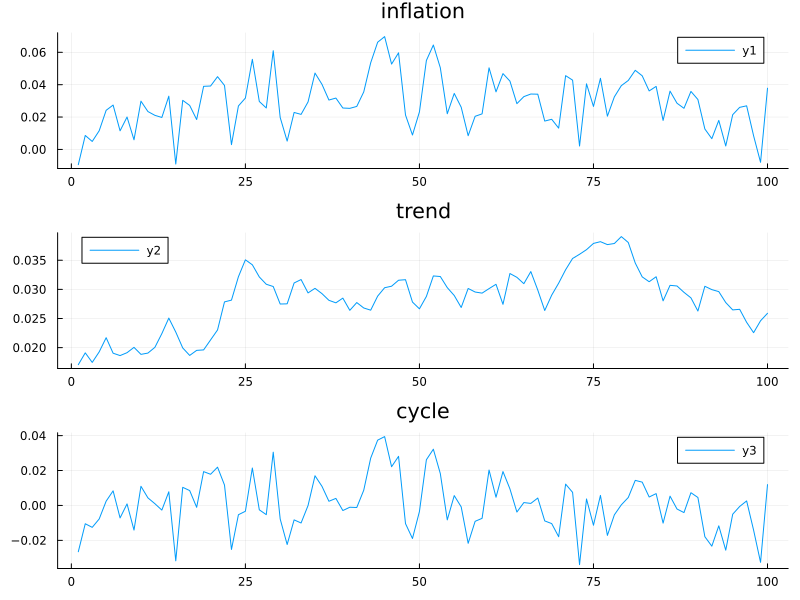

In [7]:
plot_variable_states(data[:, 1], true_states[:, [1,3]], ["inflation" "trend" "cycle"])

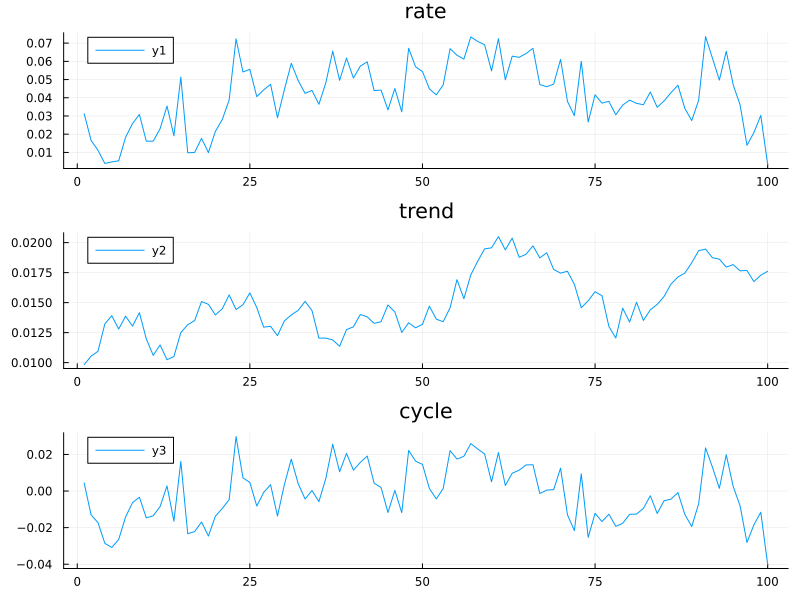

In [8]:
plot_variable_states(data[:, 2], true_states[:, [2,4]], ["rate" "trend" "cycle"])

In [9]:
priors = (
        initial_trend_mean = [mean(presample_data[:,1], dims=1)[1], mean(presample_data[:,2] - presample_data[:,1], dims=1)[1]],
        trend_covariance_df = 100,
        trend_covariance_mean = true_trend_covariance * (100 + 2 +1) #diagm([2, 1].^2/100) * (100 + 2 +1),
        )

(initial_trend_mean = [0.016478904661925038, 0.004339951032321762], trend_covariance_df = 100, trend_covariance_mean = [0.000412 0.0; 0.0 0.000103])

In [10]:
state_smoothed_samples, trend_covariance_samples = gibs_sampler(data, priors, 1_000)

state_smoothed_mean, state_smoothed_lower, state_smoothed_upper = compute_posterior_statistics(state_smoothed_samples, credible_level=0.95)  

([0.014628120836651808 0.007005283306711573 -0.024053029330969766 0.0095885922090675; 0.014779415192069904 0.006983054344691943 -0.0061681065755266225 -0.0051586624067459855; … ; 0.01951217406561277 0.012970122036488577 -0.027467234628671896 -0.0022455805786571878; 0.019673188510486286 0.012881003004205182 0.018085398835909115 -0.029303879171727297], [0.003689849530903168 -0.003052725736693926 -0.03452661845073265 -0.0032414142939405253; 0.0041020053717537265 -0.0023989338491608144 -0.01647587249450369 -0.01772766012652932; … ; 0.008391571850967592 0.0033905167376887054 -0.03773242573756744 -0.012878453823489735; 0.008538831818582528 0.0025463122330423847 0.007549169243198015 -0.040371372664611924], [0.0250954332716089 0.017443924775818697 -0.013122929673540047 0.022844520717722156; 0.02507721231679236 0.017180883008797943 0.0043741378067009475 0.006993448718694035; … ; 0.029768121578730374 0.022822853965943274 -0.016346165277688444 0.009449607342197233; 0.03015270262184294 0.022844326

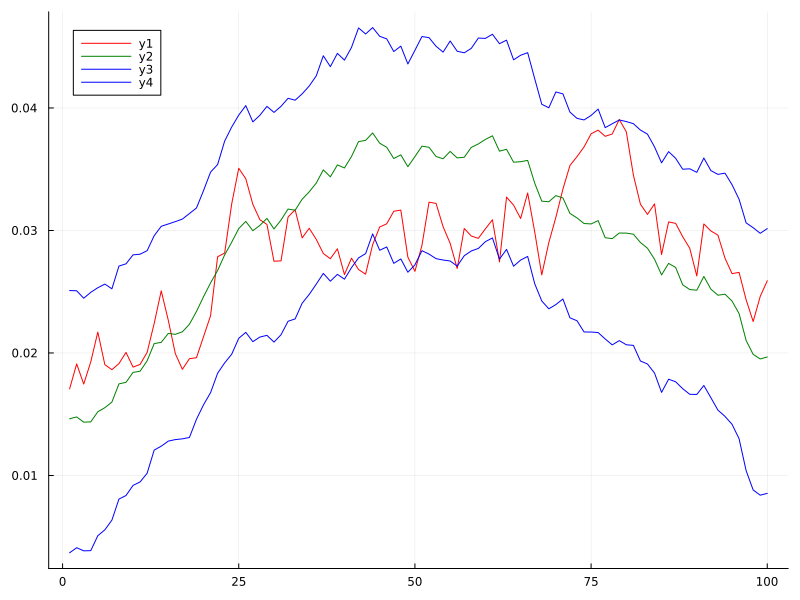

In [11]:
st = 1
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

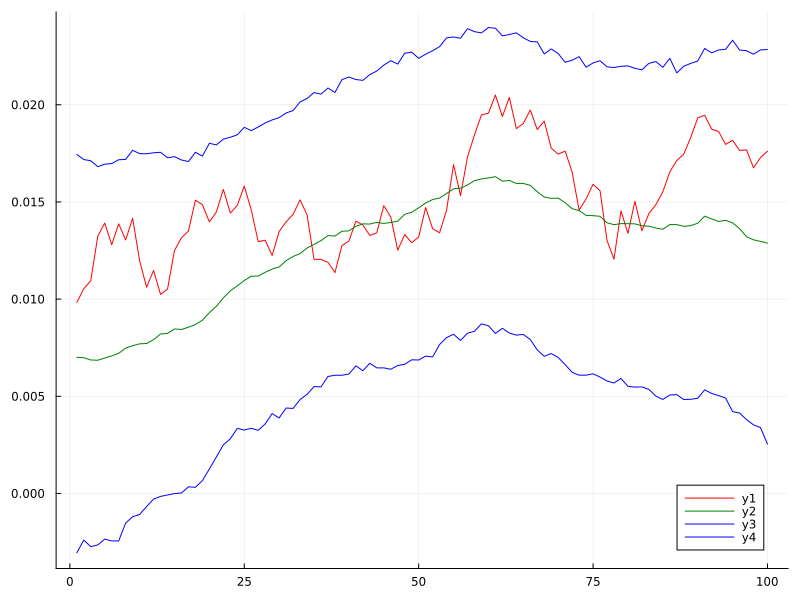

In [12]:
st = 2
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

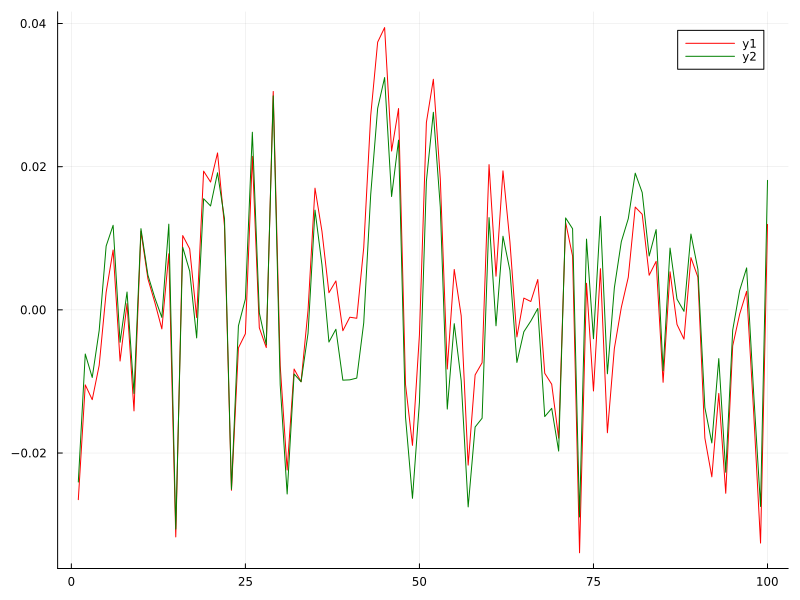

In [13]:
st = 3
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_smoothed_mean[:,st], color="green" )
#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

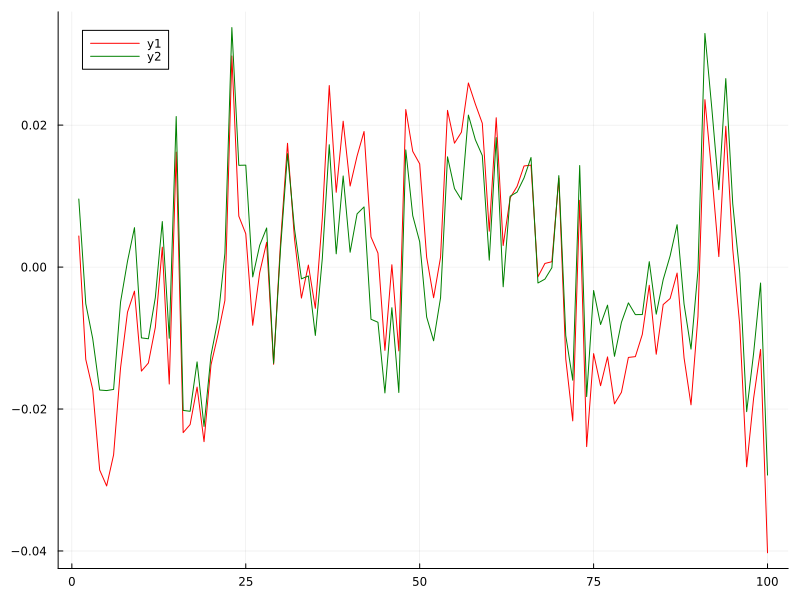

In [14]:
st = 4
plot(true_states[:,st]; color="red", size= (800, 600))

plot!(state_smoothed_mean[:,st], color="green" )
#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

In [15]:
Y = true_states[:,[1,2]]
e  = diff(Y, dims=1)
true_var = e' * e * 1/(size(Y,1)-1)
display(diag(true_var))
display(diag(true_var).^.5)

2-element Vector{Float64}:
 4.038294309780141e-6
 1.1774868172061122e-6

2-element Vector{Float64}:
 0.0020095507731281988
 0.0010851206463827476

In [16]:
summarystats(trend_covariance_samples)

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

       Στ[1]    0.0000    0.0000    0.0000   394.6287   593.2394    1.0021     ⋯
       Στ[2]    0.0000    0.0000    0.0000   360.3809   709.0992    1.0004     ⋯
       Στ[3]    0.0000    0.0000    0.0000   360.3809   709.0992    1.0004     ⋯
       Στ[4]    0.0000    0.0000    0.0000   356.3111   602.0473    1.0004     ⋯
                                                                1 column omitted


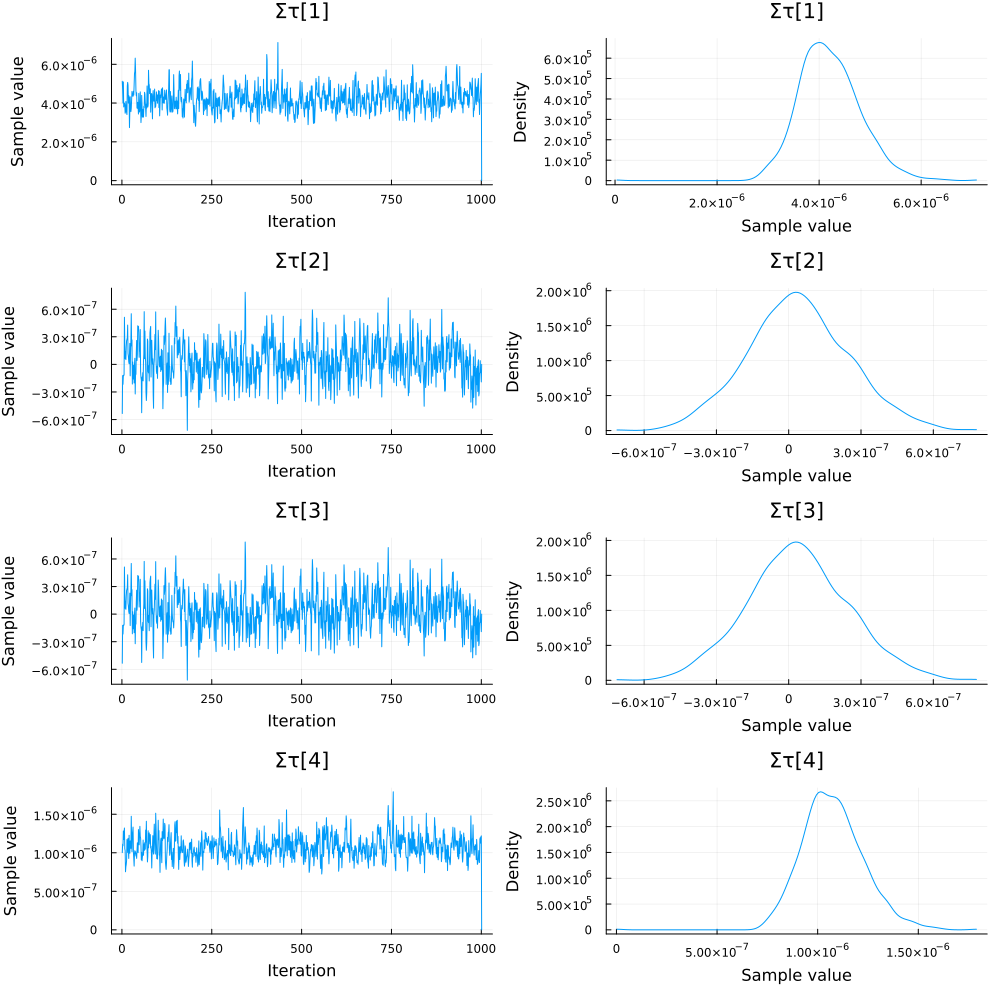

In [17]:
plot(trend_covariance_samples)

In [18]:
beta_mean_prior, beta_var_prior = minnesota_priors([0.015, 0.011] .^.5 , λ1=0.2, λ2=1., λ3=1.0, p=1, zero_ownlag=[true, true])


([0.0, 0.0, 0.0, 0.0], [0.2 0.2335496832484569; 0.17126976771553507 0.2])

In [19]:
d_post = size(data, 1) - 1 + priors.trend_covariance_df

post_dist = covariance_posterior(true_states[:,[1,2]], priors.trend_covariance_mean, d_post)

InverseWishart{Float64, PDMats.PDMat{Float64, Matrix{Float64}}}(
df: 199.0
Ψ: [0.0008117911366682339 3.589514310070821e-5; 3.589514310070821e-5 0.0002195711949034051]
)


In [20]:
true_var + priors.trend_covariance_mean

2×2 Matrix{Float64}:
 0.000416038  3.62577e-7
 3.62577e-7   0.000104177

In [21]:
cov_posterior = zeros(10_000, 2)

for n in 1:10_000
  cov_posterior[n,:,:] = diag(rand(post_dist))
end


display(mean(cov_posterior, dims=1) .* 100)
display(mean(cov_posterior, dims=1).^.5 *10) 
display(mode(cov_posterior[1]).^.5 * 10) 
display(mode(cov_posterior[2]).^.5 * 10) 

1×2 Matrix{Float64}:
 0.000415081  0.000112111

1×2 Matrix{Float64}:
 0.0203735  0.0105883

0.021496997054918508

0.019984575752999632

In [22]:
diag(true_trend_covariance) .^.5 * 10

2-element Vector{Float64}:
 0.02
 0.01

In [23]:
true_trend_covariance .^.5 .*10

2×2 Matrix{Float64}:
 0.02  0.0
 0.0   0.01

In [24]:
diag(priors.trend_covariance_mean) .^.5 *10

2-element Vector{Float64}:
 0.20297783130184438
 0.10148891565092219

In [25]:
stds = zeros(50_000, 2)


for n in 1:50_000
    stds[n,:] = diag(rand(InverseWishart(priors.trend_covariance_df, priors.trend_covariance_mean)))
end

display(mean(stds, dims=1).^.5 .*10)
display(mode(stds[1]) ^.5 * 10) 
display(mode(stds[2]) ^.5 * 10) 


1×2 Matrix{Float64}:
 0.0206186  0.0103065

0.020802654929248657

0.01939359261002412

In [26]:
stds = std.(eachcol(true_states[:,[3, 4]]))

2-element Vector{Float64}:
 0.015130117906334941
 0.015253249658775024

In [27]:
stds[2]/stds[1] * 0.2

0.20162763771177922

In [37]:
φ, Ω =  minnesota_priors([.015, .011] .^.5, λ1=0.2, λ2=1., λ3=1.0, p=1, zero_ownlag=[true, true])

display(reshape(φ, 2, 2))

Ω

2×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0

2×2 Matrix{Float64}:
 0.2      0.23355
 0.17127  0.2

In [40]:
(1 ./ Ω)' *  Ω

2×2 Matrix{Float64}:
 2.0     2.3355
 1.7127  2.0

In [41]:
Y, X = prepare_var_data(true_states[:, [3,4]], 1)

inv(X'X)*X'*Y

2×2 Matrix{Float64}:
 0.395591  0.395322
 0.193388  0.730879

In [42]:
posterior_beta_coefficient(Y, X, reshape(φ, 2, 2), Ω)

2×2 Matrix{Float64}:
  0.108784  -0.126577
 -0.126075   0.149553

In [43]:
display(true_var_coeff)
display(true_cycle_covariance)

2×2 Matrix{Float64}:
 0.3  0.1
 0.4  0.6

2×2 Matrix{Float64}:
  0.000225   -0.0001155
 -0.0001155   0.000121

uncoditional variance

In [33]:
uv = inv(I(4) - kron(true_var_coeff, true_var_coeff)) * vec(true_cycle_covariance)
reshape(uv, 2, 2)

2×2 Matrix{Float64}:
  0.000242794  -9.71144e-5
 -9.71144e-5    0.000176925

In [34]:
kron(I(2), I(2)) * vec(true_cycle_covariance)

4-element Vector{Float64}:
  0.000225
 -0.00011549999999999997
 -0.00011549999999999997
  0.00012099999999999999

In [35]:
uv = inv(I(4) - kron(zeros(2,2), zeros(2,2))) * vec(true_cycle_covariance)

4-element Vector{Float64}:
  0.000225
 -0.00011549999999999997
 -0.00011549999999999997
  0.00012099999999999999

In [36]:
kron(zeros(2,2), zeros(2,2))

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0